# CSC 8614 - Language Models
## CI2 - Fine-tuning a language model for text classification

In this TP, you will work on fine-tuning a language model to move from text generation to text classification, specifically working on Spam Detection.

The exercise (and code) has been adapted from the book _Build a Large Language Model (From Scratch)_, by Sebastian Raschka, and its [official github repository](https://github.com/rasbt/LLMs-from-scratch).

This TP will be done in this notebook, and requires some additional files (available from the course website). You will have to fill the missing portions of code, and perform some additional experiments by testing different parameters.

Working on this TP:
- The easiest way is probably to work directly on the notebook, using jupyter notebook or visual studio code. An alternative is also to use Google colab.
- You should be able to run everything on your machine, but you can connect to the GPUs if needed.

Some files are required, and are available on the course website:
- `requirements.txt`
- `gpt_utils.py`


## About the report
You will have to return this notebook (completed), as well as a mini-report (`TP2/rapport.md`).

The notebook and report shall be submitted via a GitHub repository, similarly to what you did for the first session (remember to use a different folder: `TP2`).
For the notebook, it is sufficient to complete the code and submit the final version.

For the mini-report, you have to answer the questions asked in this notebook, and discuss some of your findings as requested.
As for the first session:
- "Vous devez y mettre : réponses courtes, résultats observés (copie de sorties), captures d’écran demandées, et une courte interprétation."
- "Ne collez pas des pages entières : soyez concis et sélectionnez les éléments pertinents."

Reproducibility: 
- fix a random seed and write it in the report
- indicate in the report the specific python version OS, and the library versions.

**Question 1**: Dans `TP1/rapport.md`, ajoutez immédiatement un court en-tête (quelques lignes) contenant : (i) votre nom/prénom, (ii) la commande d’installation/activation d’environnement utilisée, (iii) les versions (Python + bibliothèques principales).

Ajoutez ensuite au fil du TP des sections/titres à votre convenance, tant que l’on peut retrouver clairement vos réponses et vos preuves d’exécution.

In [1]:
# [Instructor code: install requirements]
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Preparing the model

In [2]:
# --- [INSTRUCTOR CODE: load the model weights into memory] ---
import torch
import tiktoken
from gpt_utils import GPTModel, download_and_load_gpt2, load_weights_into_gpt

# Download the model weights (124M param version) / This function (which we put in gpt_utils) handles the downloading
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2_weights")
print("Weights downloaded and loaded into memory.")

c:\Users\jaaad\csc8614\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


File already exists and is up-to-date: gpt2_weights\124M\checkpoint
File already exists and is up-to-date: gpt2_weights\124M\encoder.json
File already exists and is up-to-date: gpt2_weights\124M\hparams.json
File already exists and is up-to-date: gpt2_weights\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2_weights\124M\model.ckpt.index
File already exists and is up-to-date: gpt2_weights\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2_weights\124M\vocab.bpe
Weights downloaded and loaded into memory.


The `settings` obtained with `download_and_load_gpt2` are the GPT-2 weights made publicly available by OpenAI.

**Question 2**: What type is the object `setting`, and what is its structure (e.g. if it is a list, its length; if a dictionary, its keys, etc.)?

**Question 3**: What type is the object `params`, and what is its structure?

In [3]:
# -------------------------------
# TP2 – GPT-2 Spam Detection Setup
# Questions 2, 3, 4
# -------------------------------

# Step 0: Imports and reproducibility
import torch
import random
import numpy as np
from gpt_utils import GPTModel, download_and_load_gpt2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Step 1: Download GPT-2 124M weights
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2_weights")
print("Weights downloaded and loaded into memory.\n")

# -------------------------------
# Question 2: Analyse settings
# -------------------------------
print("=== Question 2: Settings ===")
print("Type of settings:", type(settings))
print("Keys of settings:", settings.keys())

# Example: print key hyperparameters
print("n_layer:", settings.get("n_layer"))
print("n_head:", settings.get("n_head"))
print("n_embd:", settings.get("n_embd"))
print("vocab_size:", settings.get("vocab_size"))
print("act_fn:", settings.get("act_fn"))
print()

# -------------------------------
# Question 3: Analyse params
# -------------------------------
print("=== Question 3: Params ===")
print("Type of params:", type(params))
print("Number of parameters:", len(params))
print("Some parameter keys:", list(params.keys())[:10])


File already exists and is up-to-date: gpt2_weights\124M\checkpoint
File already exists and is up-to-date: gpt2_weights\124M\encoder.json
File already exists and is up-to-date: gpt2_weights\124M\hparams.json
File already exists and is up-to-date: gpt2_weights\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2_weights\124M\model.ckpt.index
File already exists and is up-to-date: gpt2_weights\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2_weights\124M\vocab.bpe
Weights downloaded and loaded into memory.

=== Question 2: Settings ===
Type of settings: <class 'dict'>
Keys of settings: dict_keys(['n_vocab', 'n_ctx', 'n_embd', 'n_head', 'n_layer'])
n_layer: 12
n_head: 12
n_embd: 768
vocab_size: None
act_fn: None

=== Question 3: Params ===
Type of params: <class 'dict'>
Number of parameters: 5
Some parameter keys: ['blocks', 'b', 'g', 'wpe', 'wte']


Look at the `GPTModel` in the file `gpt_utils.py`. In the `__init__` method, we have to pass a config (parameter `cfg`). 

**Question 4:** 
Analyse the `__init__` method, and check what is the required structure for the `cfg` parameter. Is the `settings` variable we have obtained in the right format? If not, perform the mapping to convert the variable `setting` into a variable `model_config` with the right structure.

In [4]:
# -------------------------------
# Question 4: Map settings to model_config
# -------------------------------

# Fixed values for GPT-2 124M
vocab_size = 50257
context_length = 1024
emb_dim = settings["n_embd"]
n_layers = settings["n_layer"]
n_heads = settings["n_head"]      # required by TransformerBlock
drop_rate = 0.1
qkv_bias = True

model_config = {
    "vocab_size": vocab_size,
    "emb_dim": emb_dim,
    "context_length": context_length,
    "drop_rate": drop_rate,
    "n_layers": n_layers,
    "n_heads": n_heads,        # must include for TransformerBlock
    "drop_rate": 0.1,
    "qkv_bias": True,     # must include for TransformerBlock
}



In [5]:
model = GPTModel(model_config)

# Load the pre-trained weights
load_weights_into_gpt(model, params)
model.eval() 

print("GPT-2 Model Loaded and Configured successfully!")

GPT-2 Model Loaded and Configured successfully!


## Preparing the data

Context from the lecture: The raw data is just text messages. 

The model needs numbers (token IDs). We also need to pad the messages so they are all the same length in a batch.

We will use a `SpamDataset` class (provided below) to tokenize the text.

In [6]:
# --- [INSTRUCTOR CODE: Run this cell to define the Dataset Class] ---
from torch.utils.data import Dataset
import pandas as pd
import urllib.request
import zipfile
import os

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=120, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_token_id = pad_token_id
        # Encode labels: "spam" -> 1, "ham" -> 0
        self.data["label_encoded"] = self.data["Label"].map({"spam": 1, "ham": 0})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]["Text"]
        label = self.data.iloc[idx]["label_encoded"]
        # Tokenize
        encoded = self.tokenizer.encode(text, allowed_special={'<|endoftext|>'})       
        # Truncate if too long
        encoded = encoded[:self.max_length]
        # Pad if too short
        pad_len = self.max_length - len(encoded)
        encoded += [self.pad_token_id] * pad_len
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Download the dataset zip file
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extract_path = "sms_spam_collection"
data_file_path = os.path.join(extract_path, "SMSSpamCollection")
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_path)
    print("Download complete.")
# Unzip
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
# Read the TSV file
df = pd.read_csv(
    data_file_path, 
    sep="\t", 
    header=None, 
    names=["Label", "Text"]
)
print(f"Total samples loaded: {len(df)}")

# 4. Create Train/Test Split (80 train / 20 test)
df = df.sample(frac=1, random_state=123).reset_index(drop=True)
# Split index
split_idx = int(0.8 * len(df))

# TODO: if needed (for performance resons), you can come back here and reduce the size of the training set.
train_df = df.iloc[:split_idx]  # [:2000]  # Readd this to only consider 2000 training samples
test_df = df.iloc[split_idx:]

# Save as CSVs, so the SpamDataset class can read them.
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)
print("Created 'train.csv' and 'test.csv' successfully!")
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Total samples loaded: 5572
Created 'train.csv' and 'test.csv' successfully!
Train size: 4457
Test size: 1115


**Question 5.1**: In the cell above, why did we do `df = df.sample(frac=1, random_state=123)` when creating the train/test split?

**Question 5.2**: Analyse the datasets, what is the distribution of the two classes in the train set? Are they balanced or unbalanced? In case they are unbalanced, might this lead to issues for the fine-tuning of the model?

Class distribution in training set:
Label
ham     3860
spam     597
Name: count, dtype: int64

Class percentages:
Label
ham     86.60534
spam    13.39466
Name: count, dtype: float64


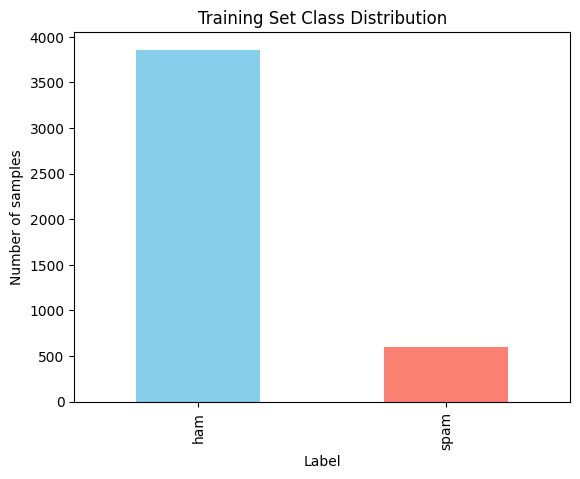

In [7]:
# Load the train dataset
train_data = pd.read_csv("train.csv")

# Count class distribution
class_counts = train_data["Label"].value_counts()
print("Class distribution in training set:")
print(class_counts)

# Compute percentages
class_percent = 100 * class_counts / len(train_data)
print("\nClass percentages:")
print(class_percent)

import matplotlib.pyplot as plt

class_counts.plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Training Set Class Distribution")
plt.ylabel("Number of samples")
plt.show()


**Question 6**: Create the dataloaders for training and test.

In [ ]:
from torch.utils.data import DataLoader

# Tokenizer already created
tokenizer = tiktoken.get_encoding("gpt2")

# Dataset instances
train_dataset = SpamDataset("train.csv", tokenizer)
test_dataset = SpamDataset("test.csv", tokenizer)

# Create DataLoaders
batch_size = 16

# 1. Train loader: shuffle=True
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# 2. Test loader: shuffle=False
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


Input batch shape: torch.Size([16, 120])
Target batch shape: torch.Size([16])


In [9]:
# Check your work
for input_batch, target_batch in train_loader:
    print("Input batch shape:", input_batch.shape) # Should be [16, 120] (unless you use batch_size != 16)
    print("Target batch shape:", target_batch.shape) # Should be [16]
    break

Input batch shape: torch.Size([16, 120])
Target batch shape: torch.Size([16])


**Question 7**: Looking at the batch size and the training size, how many batches will you have in total? Please report the size of the subsampled training data, you reduce it due to performance constraints.

In [ ]:
subsample_size = 2000  # can reduce from full train set (~4179)
train_dataset_small = torch.utils.data.Subset(train_dataset, range(subsample_size))

batch_size = 16
num_batches = (len(train_dataset_small) + batch_size - 1) // batch_size
print(f"Subsampled training size: {len(train_dataset_small)}")
print(f"Number of batches per epoch: {num_batches}")

Subsampled training size: 2000
Number of batches per epoch: 125


## Fine-tuning

**Context**: GPT-2 was trained to predict the next word (output size ~50,000). We want to predict binary classes (output size 2), so we must replace the final layer.

**Question 8**:

**8.1**: In the cell below, define the number of output classes (`num_classes`) for the new spam detection task.

**8.2**: Also, pring the original and updated output heads (hint: `out_head` from `GPTModel`)

**8.3**: Why do we freeze the internal layers with `param.requires_grad = False`?

In [11]:
import torch.nn as nn

# Freeze the internal layers
for param in model.parameters():
    param.requires_grad = False

# Print the original output head
print(f"Original output head: {model.out_head}")

# Define number of output classes
num_classes = 2  # spam / ham

# Replace the output head
# GPT-2 small hidden size is 768
model.out_head = nn.Linear(768, num_classes)

# Enable gradient calculation ONLY for the new head and the final LayerNorm
for param in model.out_head.parameters():
    param.requires_grad = True
for param in model.trf_blocks[-1].norm2.parameters():
    param.requires_grad = True

# Print the new output head
print(f"New output head: {model.out_head}")

Original output head: Linear(in_features=768, out_features=50257, bias=False)
New output head: Linear(in_features=768, out_features=2, bias=True)


You now have to **finalise the code for the training loop** (see individual steps below).

In the first cell below you can find the code to move the model to GPU (if available), define the optimizer, and calculate the accuracy. The following cell contains the code for the training (fine-tuning) loop.

You will have to complete the code of the training loop, by answering the following questions:

**Question 9.1**: Reset the gradients of the `optimizer` ([hint](https://docs.pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)).

**Question 9.2**: Compute cross-entropy loss ([hint](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)).

**Question 9.3**: Add code for the backward pass, to compute the gradient ([hint](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html))

**Question 9.4**: Add code for the optimizer step, to update the weights ([hint](https://docs.pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html))

**Question 9.5**: Add code to calculate the accuracy on train and test (hint: you can use the `calc_accuracy` method).

**Note about the speed**: On my laptop's CPU 1 epoch with the full training dataset (~4400 samples, batch_size=16) took ~20 minutes; 1 epoch with a train set of 2000 samples (batch_size=16) took ~12 minutes. 

To iterate more quickly, you could:
- i) set `num_epochs = 1` (but only at the beginning), just to make sure that the code is working;
- ii) increase batch_size to 32 or 64 (but careful with possible memory issues).
- iii) reduce the size of the training dataset, by going back to the *Preparing the data* section, and changing the line `train_df = df.iloc[:split_idx]` to `train_df = df.iloc[:split_idx][:2000]` or similar. Be careful that if you reduce the training data too much, the model will not have enough data for fine-tuning.
- Use a GPU; it would be much quicker (few minutes on the whole training data).


In [15]:
import torch.nn as nn

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Measure imbalance
count_ham = len(train_df[train_df['Label']=='ham'])
count_spam = len(train_df[train_df['Label']=='spam'])

# Calculate class weights: penalize missing the minority class (Spam) more
pos_weight = count_ham / count_spam
class_weights = torch.tensor([1.0, pos_weight]).to(device)
print(f"Using class weights: {class_weights}")

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.1)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

def calc_accuracy(loader, model, device):
    correct, total = 0, 0
    # Track spam specifically
    spam_correct, spam_total = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)[:, -1, :]
            predicted = torch.argmax(logits, dim=-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Filter for Spam (Label 1)
            spam_mask = (labels == 1)
            spam_total += spam_mask.sum().item()
            spam_correct += (predicted[spam_mask] == labels[spam_mask]).sum().item()
    # Avoid division by zero
    spam_acc = spam_correct / spam_total if spam_total > 0 else 0.0
    global_acc = correct / total
    return global_acc, spam_acc

Using class weights: tensor([1.0000, 6.4657])


In [16]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 9.1. Reset Gradients
        optimizer.zero_grad()

        # Forward Pass (last token only)
        logits = model(inputs)[:, -1, :]  # shape: [batch_size, num_classes]

        # 9.2. Calculate the cross entropy loss
        loss = criterion(logits, targets)

        # 9.3. Backward Pass
        loss.backward()

        # 9.4 Optimizer Step
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    # 9.5 Calculate the accuracy on train and test
    train_acc, train_spam_acc = calc_accuracy(train_loader, model, device)
    test_acc, test_spam_acc = calc_accuracy(test_loader, model, device)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc*100:.2f}% (Spam: {train_spam_acc*100:.2f}%) | "
          f"Test Acc: {test_acc*100:.2f}% (Spam: {test_spam_acc*100:.2f}%)")

Epoch 1, Batch 0, Loss: 0.6500
Epoch 1, Batch 10, Loss: 0.7557
Epoch 1, Batch 20, Loss: 0.7856
Epoch 1, Batch 30, Loss: 0.7110
Epoch 1, Batch 40, Loss: 0.7362
Epoch 1, Batch 50, Loss: 0.6807
Epoch 1, Batch 60, Loss: 0.4179
Epoch 1, Batch 70, Loss: 0.6205
Epoch 1, Batch 80, Loss: 1.1277
Epoch 1, Batch 90, Loss: 0.6747
Epoch 1, Batch 100, Loss: 0.6561
Epoch 1, Batch 110, Loss: 0.5817
Epoch 1, Batch 120, Loss: 0.5092
Epoch 1, Batch 130, Loss: 0.6022
Epoch 1, Batch 140, Loss: 0.6624
Epoch 1, Batch 150, Loss: 0.3908
Epoch 1, Batch 160, Loss: 0.6139
Epoch 1, Batch 170, Loss: 0.2548
Epoch 1, Batch 180, Loss: 0.4623
Epoch 1, Batch 190, Loss: 0.5067
Epoch 1, Batch 200, Loss: 0.4477
Epoch 1, Batch 210, Loss: 0.5390
Epoch 1, Batch 220, Loss: 0.2957
Epoch 1, Batch 230, Loss: 0.7264
Epoch 1, Batch 240, Loss: 0.2122
Epoch 1, Batch 250, Loss: 0.9020
Epoch 1, Batch 260, Loss: 0.7302
Epoch 1, Batch 270, Loss: 0.3962
Epoch 1: Train Acc: 62.55% (Spam: 97.15%) | Test Acc: 64.66% (Spam: 98.00%)
Epoch 2, Ba

KeyboardInterrupt: 

**Question 10**: 

Now run the cell above. You should see how the training loss changes after each batch (and epoch).
Describe thie trend: what do you see, is the model learning?

**Question 11 (optional)**: Change the number of epochs and/or the learning rate and/or the size of the training data, and investigate how the loss/accuracy of the model changes. You can do this editing and re-running the cells above, or creating new cells below.

In [ ]:
# Changed the code directly in the previous cell. Learning Rate went from 5e-5 to 1e-3.

**Question 12 (optional)**: Now test the model *on your own text*.

In [18]:
def classify_text(text, model, tokenizer, device, max_length=120, pad_token_id=50256):
    model.eval()
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded = encoded[:max_length]
    pad_len = max_length - len(encoded)
    encoded += [pad_token_id] * pad_len
    encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(encoded_tensor)[:, -1, :]
        predicted_label = torch.argmax(logits, dim=-1).item()

    return "SPAM" if predicted_label == 1 else "NOT SPAM"

# --- Tests ---
# Texte 1 : Message conversationnel normal
text_1 = "Hey, are we still meeting for lunch tomorrow at 12?" 

# Texte 2 : Message frauduleux typique (Urgence + Gratuité + Lien)
text_2 = "URGENT! You have won a FREE iPhone. Click here to claim your prize now! Call 0800-123-456."

print(f"Text 1: '{text_1}' -> Prediction: {classify_text(text_1, model, tokenizer, device)}")
print(f"Text 2: '{text_2}' -> Prediction: {classify_text(text_2, model, tokenizer, device)}")

Text 1: 'Hey, are we still meeting for lunch tomorrow at 12?' -> Prediction: NOT SPAM
Text 2: 'URGENT! You have won a FREE iPhone. Click here to claim your prize now! Call 0800-123-456.' -> Prediction: NOT SPAM


---